# Libraries

In [2]:
import pandas as pd

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

import seaborn as sns
import arviz as az

/home/tousside/Documents/AIMS/Courses/BayesianModellingDGSE/project/epidemiology-project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

import numpyro
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
from numpyro.diagnostics import hpdi


In [4]:
numpyro.set_host_device_count(4)

# Data

In [5]:
# path to CSV file ioth data
csv_file = "influenza-england-1978-school.csv"

data = pd.read_csv(csv_file)
data = data.rename(columns={'Unnamed: 0': 't'})
data.head()

,csvbase_row_id,date,in_bed,convalescent
0,1,1978-01-22,3,0
1,2,1978-01-23,8,0
2,3,1978-01-24,26,0
3,4,1978-01-25,76,0
4,5,1978-01-26,225,9


# Visualize the data

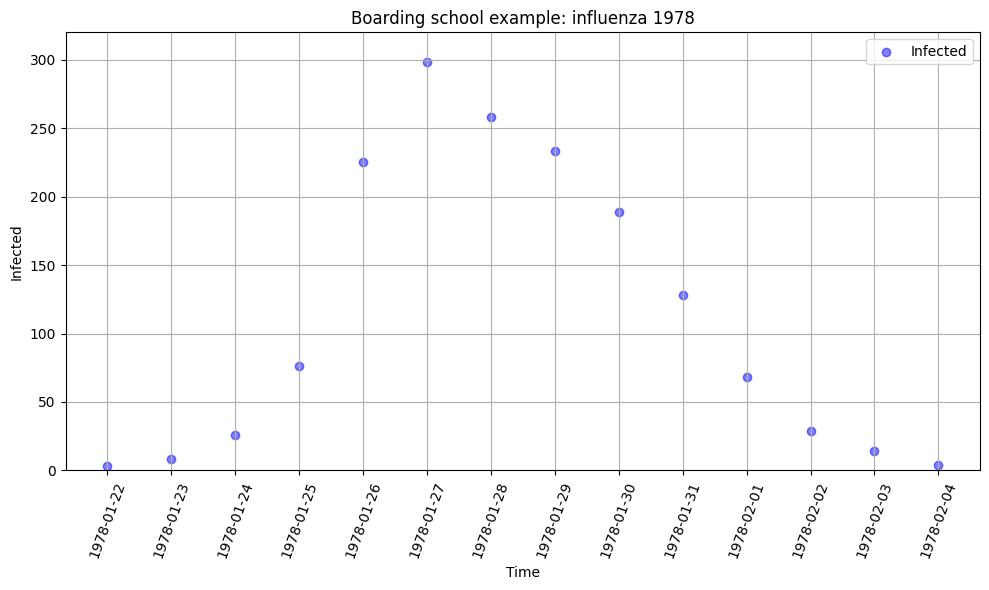

In [6]:
plt.figure(figsize=(10, 6))  

# plot 'in_bed' against 'date'
plt.scatter(data['date'], data['in_bed'], color='blue', alpha=0.5, label='Infected')

plt.xlabel('Time')
plt.ylabel('Infected')
plt.ylim(0, 320)
plt.title('Boarding school example: influenza 1978')

plt.xticks(rotation=70)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#

# Implemente the model: SIR

In [7]:
def SIR(observed_data=None, pop_size=None,  z_init=None, n_states=3):
    """
    Susceptible-Infectious (SIR) model.

    beta: infection rate (transmission rate).
    gamma: recovered rate.

    S, I : arrays representing the number of susceptible and infected individuals
           at each time step.
    """

    def dz_dt(z, t):
        S = z[0]
        I = z[1]
        R = z[2]

        dS_dt = -beta * I * S / pop_size
        dI_dt =  beta * I * S / pop_size - gamma*I
        dR_dt =  gamma * I

        return jnp.stack([dS_dt, dI_dt, dR_dt])

    if z_init is None:
        z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([n_states]))
        
    
    # prior for beta
    beta = numpyro.sample('beta',dist.TruncatedNormal(loc=2, scale=1, low=0.))
    gamma = numpyro.sample('gamma',dist.TruncatedNormal(loc=0.4, scale=0.5, low=0.))
    
    R0 = numpyro.deterministic("R0", beta / gamma)
    
    recovery_time = numpyro.deterministic("recovery_time", 1 / gamma)
        
    #Negative binomial params
    phi_inv = numpyro.sample('phi',dist.Exponential(5))
    phi = 1/phi_inv
    # integrate dz/dt, the result will have shape num_days x 2
    time = jnp.arange(len(observed_data))*1.0
    
    z = numpyro.deterministic("z", odeint(dz_dt, z_init, time, rtol=1e-6, atol=1e-5, mxstep=1000))

    # likelihood
    obs = numpyro.sample("observed", dist.NegativeBinomial2(z[:, 1]+ 1e-5, phi), obs=observed_data)
 

In [8]:
   
# observed data
observed_data = jnp.array(data['in_bed'])

# inference
nuts_kernel = NUTS(SIR)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=4, progress_bar=True)
#Initial condition
init = jnp.array([762.0, .01, 0.0])

mcmc.run(jax.random.PRNGKey(0), pop_size=763,  observed_data=observed_data,  z_init=init)


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]







# Checking the inference

In [9]:
mcmc.print_summary(exclude_deterministic=True)

Running chain 0:   0%|          | 0/2000 [00:04<?, ?it/s]































































Running chain 1: 100%|██████████| 2000/2000 [00:10<00:00, 195.24it/s]

Running chain 0: 100%|██████████| 2000/2000 [06:30<00:00,  5.13it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      3.73      1.87      4.54      0.58      5.33      2.08      4.77
     gamma      0.87      0.89      0.38      0.30      2.42      2.00     23.76
       phi      0.54      0.22      0.50      0.31      0.91      6.08      1.22

Number of divergences: 0


/home/tousside/Documents/AIMS/Courses/BayesianModellingDGSE/project/epidemiology-project/venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


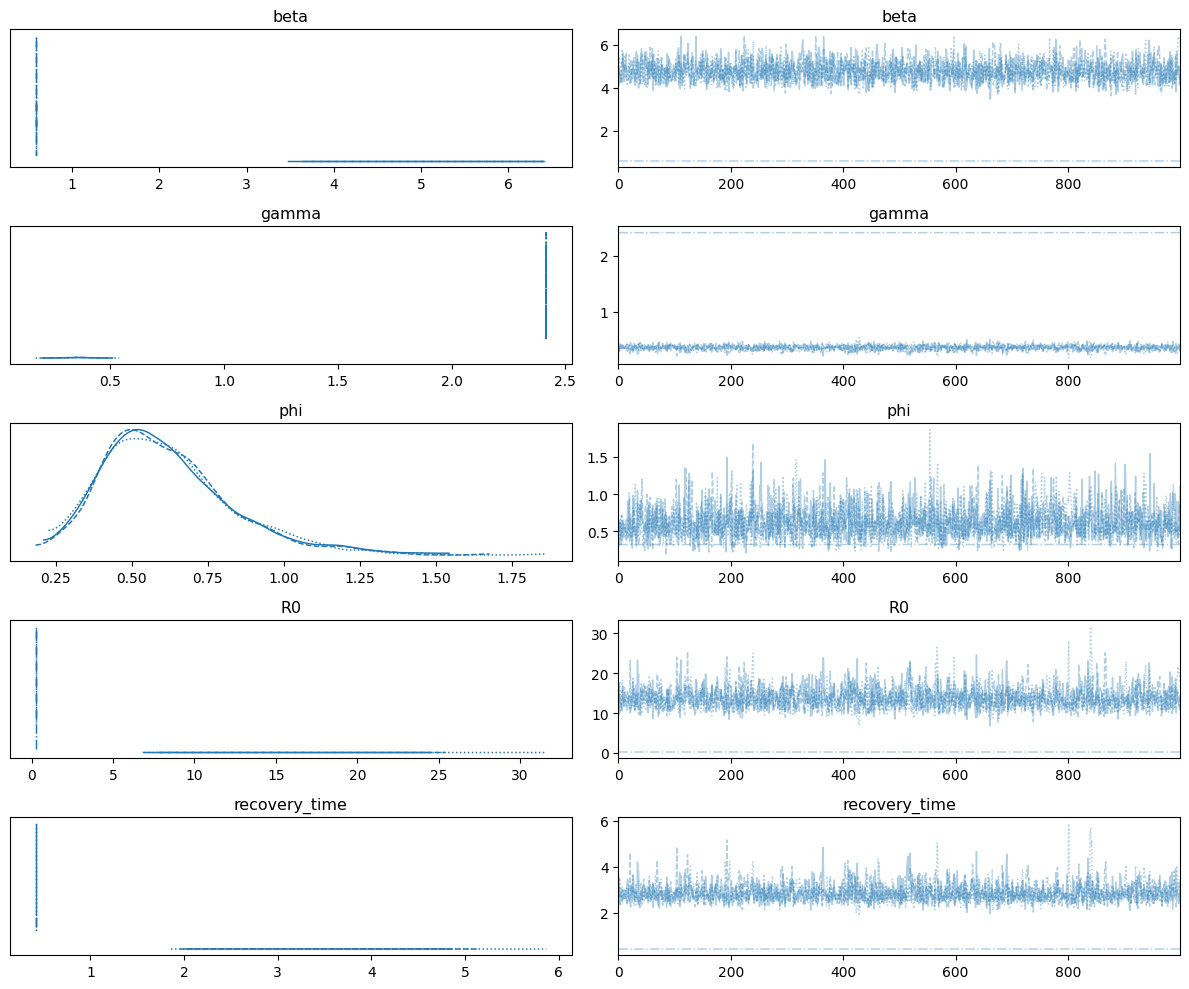

In [10]:
inf_data = az.from_numpyro(mcmc)
az.plot_trace(inf_data, compact=True, var_names=["beta", "gamma", "phi", "R0", "recovery_time"]);
plt.tight_layout()

The different chains agree with each other 

# Checking the model prediction 

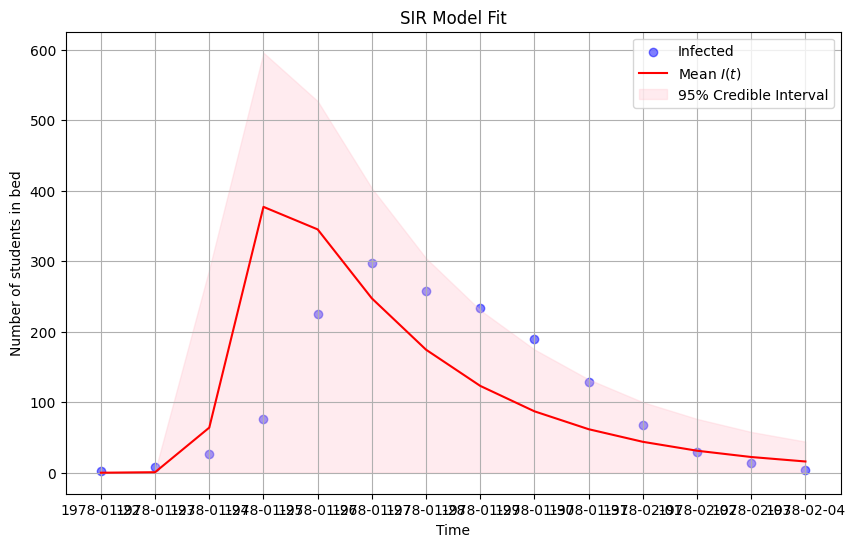

In [11]:
# extract posterior samples
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples['z']

# calculate median and credible intervals
lower_bound_infected = jnp.percentile(z_samples, 2.5, axis=0)[:, 1]
upper_bound_infected = jnp.percentile(z_samples, 97.5, axis=0)[:, 1]
mean_infected        = jnp.mean(z_samples, axis=0)[:, 1]

# plot the observed data
plt.figure(figsize=(10, 6))
plt.scatter(data['date'], data['in_bed'], color='blue', alpha=0.5, label='Infected')

# plot median of the posterior distribution
plt.plot(data['date'], mean_infected, color='red', label='Mean $I(t)$')

# plot uncertainty bounds
plt.fill_between(data['date'], lower_bound_infected, upper_bound_infected, color='pink', alpha=0.3, label='95% Credible Interval')

plt.xlabel('Time')
plt.ylabel('Number of students in bed')
plt.title('SIR Model Fit')
plt.legend()
plt.grid(True)
plt.show()

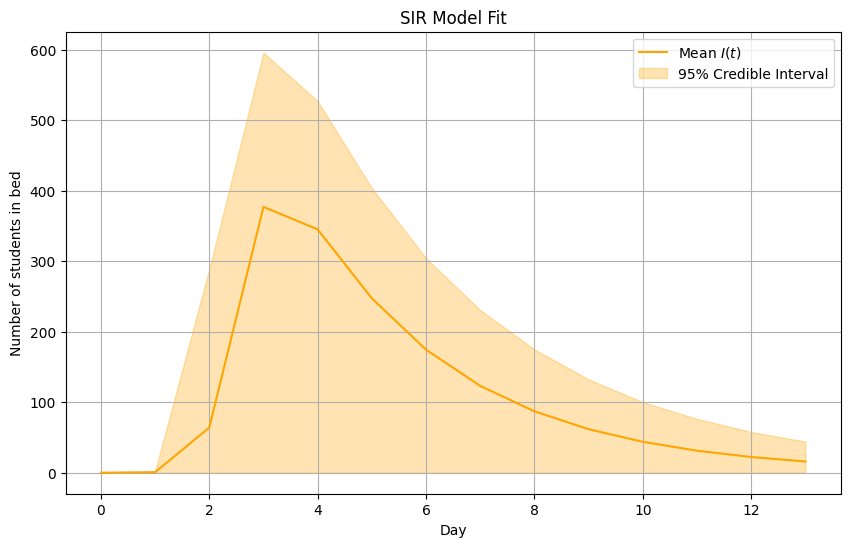

In [12]:
# extract posterior samples
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples['z']

# calculate median and credible intervals
lower_bound_infected = jnp.percentile(z_samples, 2.5, axis=0)[:, 1]
upper_bound_infected = jnp.percentile(z_samples, 97.5, axis=0)[:, 1]
mean_infected        = jnp.mean(z_samples, axis=0)[:, 1]

# plot the observed data
plt.figure(figsize=(10, 6))
# plt.scatter(data['date'], data['in_bed'], color='blue', alpha=0.5, label='Infected')

# plot median of the posterior distribution
plt.plot(jnp.arange(len(data['date'])), mean_infected, color='orange', label='Mean $I(t)$')

# plot uncertainty bounds
plt.fill_between(jnp.arange(len(data['date'])), lower_bound_infected, upper_bound_infected, color='orange', alpha=0.3, label='95% Credible Interval')

plt.xlabel('Day')
plt.ylabel('Number of students in bed')
plt.title('SIR Model Fit')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True)
plt.show()

# 2 Using simulated data to understand our model

## prior predictive

In [13]:
rng_key = jax.random.PRNGKey(0)


In [14]:
prior_predictive = Predictive(SIR, num_samples=1000)
prior_predictions = prior_predictive(rng_key, observed_data=observed_data, pop_size=763)

In [15]:
prior_predictions.keys()

dict_keys(['R0', 'beta', 'gamma', 'observed', 'phi', 'recovery_time', 'z', 'z_init'])

In [16]:
prior_predictions["beta"]

Array([3.3482366 , 2.3243654 , 3.338163  , 1.3521506 , 0.7390604 ,
       1.6444211 , 1.2093287 , 4.0209217 , 2.5741527 , 3.1450148 ,
       2.296664  , 2.5344934 , 2.151866  , 0.7179098 , 0.3577838 ,
       2.532694  , 0.97758675, 3.4307823 , 2.946134  , 1.3241818 ,
       1.9925302 , 2.2387428 , 1.1695342 , 3.1227345 , 3.2277398 ,
       2.4256668 , 2.8787243 , 1.3001282 , 0.2649535 , 2.3481016 ,
       1.1625688 , 1.7074234 , 0.937677  , 3.1112146 , 0.470899  ,
       1.9139073 , 2.0217905 , 1.6227243 , 2.5837114 , 1.0896497 ,
       0.08063698, 4.0227013 , 2.807246  , 2.1976922 , 2.5194767 ,
       2.8213117 , 0.50506616, 1.8981601 , 3.304264  , 2.4294975 ,
       1.6760498 , 1.7307432 , 0.8164966 , 2.3979223 , 0.8903439 ,
       1.5303624 , 1.8660026 , 1.391284  , 1.3669498 , 1.0365503 ,
       2.685698  , 1.3658834 , 2.9183862 , 4.221403  , 2.6027055 ,
       4.2824306 , 2.866856  , 2.8292665 , 1.312118  , 2.202647  ,
       1.8956659 , 0.6654848 , 1.178005  , 2.3198488 , 1.99416

In [17]:
# extract samples for variable 'p'
pred_obs = prior_predictions['beta']

# compute its summary statistics for the samples of `p`
mean_prior_pred = jnp.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)

TypeError: gaussian_kde.__init__() got an unexpected keyword argument 'shade'

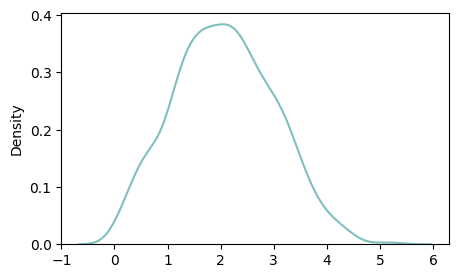

In [18]:
fig = plt.figure(dpi=100, figsize=(5, 3))
sns.kdeplot(pred_obs, alpha=0.5, color='teal')
x = jnp.linspace(0, 1, 3000)
kde = gaussian_kde(pred_obs, shade = True)
# plt.plot(x, kde(x), color='teal', lw=3, alpha=0.5)
plt.xlabel('Bata')
# plt.title(f'Prior predictive distribution for $\beta$')
plt.xlim(0, 1)
plt.grid(0.3)
plt.show()

In [ ]:

rng_key, rng_key_ = jax.random.split(rng_key)
prior_predictive = Predictive(SIR, observed_data=observed_data)
# prior_predictions = prior_predictive(rng_key_, "R0")

TypeError: Predictive.__init__() got an unexpected keyword argument 'observed_data'